In [168]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.opflow import Gradient, NaturalGradient
from qiskit.utils import QuantumInstance


from qiskit_machine_learning.neural_networks import TwoLayerQNN, OpflowQNN
from qiskit_machine_learning.algorithms import VQC, NeuralNetworkClassifier
from qiskit_machine_learning.datasets import ad_hoc_data

In [167]:
"""A standard gradient descent optimizer."""

from typing import Iterator, Optional, Union, Callable
from functools import partial

import numpy as np

from qiskit.algorithms.optimizers import Optimizer, OptimizerSupportLevel

CALLBACK = Callable[[int, np.ndarray, float], None]


class GradientDescent(Optimizer):

    def __init__(
        self,
        maxiter: int = 100,
        learning_rate: Union[float, Callable[[], Iterator]] = 0.01,
        tol: float = 1e-7,
        callback: Optional[CALLBACK] = None,
        perturbation: Optional[float] = None,
    ) -> None:
        super().__init__()

        self.maxiter = maxiter
        self.learning_rate = learning_rate
        self.perturbation = perturbation
        self.tol = tol
        self.callback = callback

    def _minimize(self, loss, grad, initial_point):
        # set learning rate
        if isinstance(self.learning_rate, float):
            eta = constant(self.learning_rate)
        else:
            eta = self.learning_rate()

        if grad is None:
            eps = 0.01 if self.perturbation is None else self.perturbation
            grad = partial(
                Optimizer.gradient_num_diff,
                f=loss,
                epsilon=eps,
                max_evals_grouped=self._max_evals_grouped,
            )

        # prepare some initials
        x = np.asarray(initial_point)
        nfevs = 0

        for _ in range(1, self.maxiter + 1):
            # compute update -- gradient evaluation counts as one function evaluation
            update = grad(x)
            nfevs += 1

            # compute next parameter value
            x_next = x - next(eta) * update

            # send information to callback
            if self.callback is not None:
                self.callback(nfevs, x_next, loss(x_next), np.linalg.norm(update))

            # update parameters
            x = x_next

            # check termination
            if np.linalg.norm(update) < self.tol:
                break

        return x, loss(x), nfevs

    def get_support_level(self):
        """Get the support level dictionary."""
        return {
            "gradient": OptimizerSupportLevel.supported,
            "bounds": OptimizerSupportLevel.ignored,
            "initial_point": OptimizerSupportLevel.required,
        }

    # pylint: disable=unused-argument
    def optimize(
        self,
        num_vars,
        objective_function,
        gradient_function=None,
        variable_bounds=None,
        initial_point=None,
    ):
        return self._minimize(objective_function, gradient_function, initial_point)


def constant(eta=0.01):
    """Yield a constant."""

    while True:
        yield eta


In [16]:
q_instance = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=8192)

In [130]:
training_features, training_labels, test_features, test_labels = ad_hoc_data(
    training_size=20, test_size=10, n=2, gap=0.5
)
binary_training_labels = np.array([-1. if label[0] == 0 else 1. for label in training_labels])
binary_test_labels = np.array([-1. if label[0] == 0 else 1. for label in test_labels])

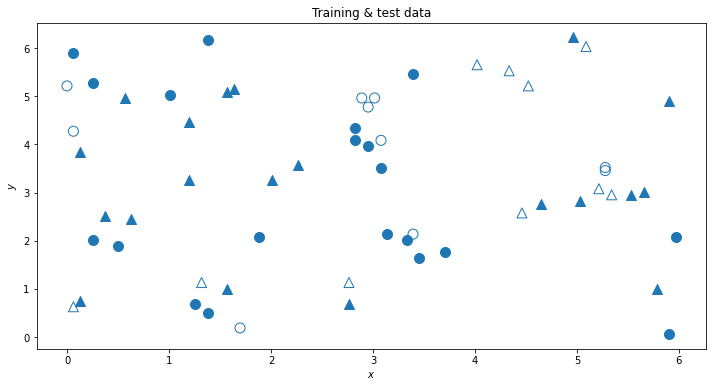

In [131]:
plt.figure(figsize=(12,6))

# training features


# test features
# color_a, color_b = [], []
# for predicted, correct in zip(predicted_labels, test_labels):
#     if correct[0] == 0:
#         color_a.append('tab:green' if predicted[0] == correct[0] else 'tab:red')
#     else:
#         color_b.append('tab:green' if predicted[0] == correct[0] else 'tab:red')

for feature, label in zip(training_features, training_labels):
    marker = 'o' if label[0] == 1 else '^'
    plt.scatter(feature[0], feature[1], marker=marker, s=100, color='tab:blue')
    
for feature, label in zip(test_features, test_labels):
    marker = 'o' if label[0] == 1 else '^'
    plt.scatter(feature[0], feature[1], marker=marker, s=100, facecolor='none', edgecolor='tab:blue')
    
plt.title('Training & test data')
plt.xlabel('$x$')
plt.ylabel('$y$');
# plt.legend(bbox_to_anchor=(1.2, 0.5));

In [ ]:
np.random.seed(4)
initial_point = np.random.random(ansatz.num_parameters)

## With ``VQC``

In [95]:
ansatz = RealAmplitudes(2)
feature_map = ZZFeatureMap(2)

vqc = VQC(ansatz=ansatz,
          feature_map=feature_map,
          loss='cross_entropy',
          optimizer=COBYLA(),
          quantum_instance=q_instance)

In [96]:
vqc.fit(training_features, training_labels)

In [97]:
predicted_labels = vqc.predict(test_features)

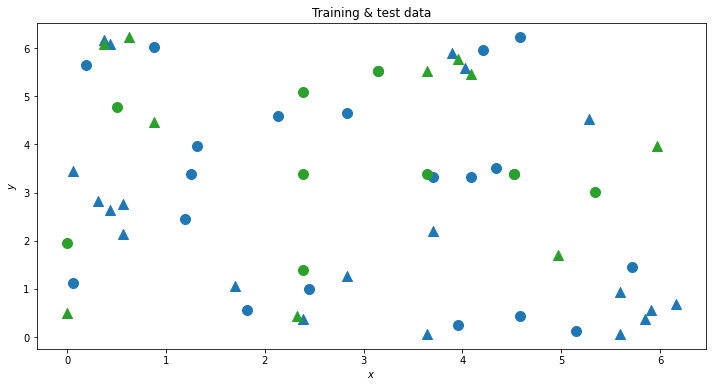

In [98]:
plt.figure(figsize=(12,6))

for feature, label in zip(training_features, training_labels):
    marker = 'o' if label[0] == 1 else '^'
    plt.scatter(feature[0], feature[1], marker=marker, s=100, color='tab:blue')
    
for feature, label, predicted in zip(test_features, test_labels, predicted_labels):
    marker = 'o' if label[0] == 1 else '^'
    color = 'tab:green' if label[0] == predicted[0] else 'tab:red'
    plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
plt.title('Training & test data')
plt.xlabel('$x$')
plt.ylabel('$y$');

## With ``TwoLayerQNN``

In [162]:
twolayer_qnn = TwoLayerQNN(num_qubits=2, ansatz=ansatz, feature_map=feature_map, quantum_instance=q_instance)
twolayer_classifier = NeuralNetworkClassifier(twolayer_qnn, loss='l2', optimizer=COBYLA())

In [163]:
twolayer_classifier.fit(training_features, binary_training_labels)

In [164]:
twolayer_classifier.score(training_features, binary_training_labels)

1.0

In [165]:
twolayer_predicted = twolayer_classifier.predict(test_features)

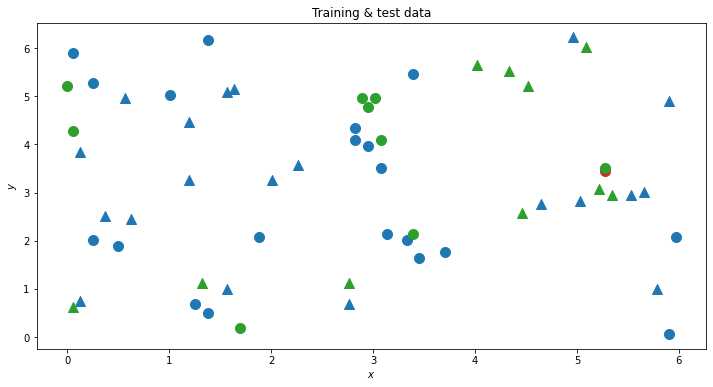

In [166]:
plt.figure(figsize=(12,6))

for feature, label in zip(training_features, training_labels):
    marker = 'o' if label[0] == 1 else '^'
    plt.scatter(feature[0], feature[1], marker=marker, s=100, color='tab:blue')
    
for feature, label, predicted in zip(test_features, binary_test_labels, twolayer_predicted):
    marker = 'o' if label == 1 else '^'
    color = 'tab:green' if label == predicted else 'tab:red'
    plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
plt.title('Training & test data')
plt.xlabel('$x$')
plt.ylabel('$y$');

## With ``OpflowQNN``

In [143]:
from qiskit.opflow import PauliSumOp

In [152]:
circuit = feature_map.compose(ansatz)
operator = PauliSumOp.from_list([("Z" * 2, 1)])
expectation = StateFn(operator, is_measurement=True) @ StateFn(circuit)

In [153]:
operator.to_pauli_op()

PauliOp(Pauli('ZZ'), coeff=1.0)

In [157]:
opflow_qnn = OpflowQNN(expectation, 
                       input_params=list(feature_map.parameters), 
                       weight_params=list(ansatz.parameters),
                       quantum_instance=q_instance)
opflow_classifier = NeuralNetworkClassifier(opflow_qnn, loss='l2', optimizer=COBYLA())

In [158]:
opflow_classifier.fit(training_features, binary_training_labels)

In [159]:
opflow_classifier.score(training_features, binary_training_labels)

1.0

In [160]:
opflow_predicted = opflow_classifier.predict(test_features)

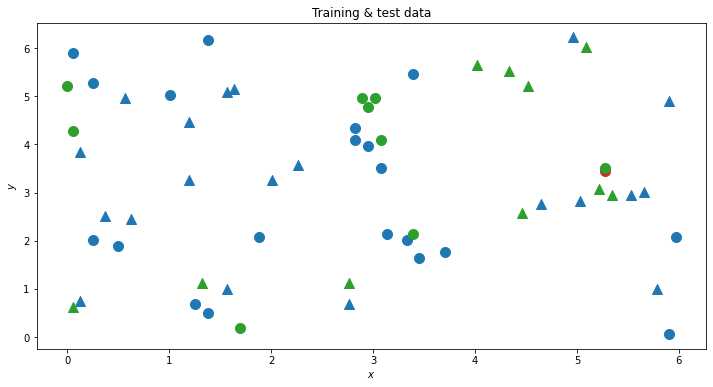

In [161]:
plt.figure(figsize=(12,6))

for feature, label in zip(training_features, training_labels):
    marker = 'o' if label[0] == 1 else '^'
    plt.scatter(feature[0], feature[1], marker=marker, s=100, color='tab:blue')
    
for feature, label, predicted in zip(test_features, binary_test_labels, opflow_predicted):
    marker = 'o' if label == 1 else '^'
    color = 'tab:green' if label == predicted else 'tab:red'
    plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
plt.title('Training & test data')
plt.xlabel('$x$')
plt.ylabel('$y$');

## ``OpflowQNN`` and gradients

In [169]:
opflow_qnn = OpflowQNN(expectation, 
                       input_params=list(feature_map.parameters), 
                       weight_params=list(ansatz.parameters),
                       quantum_instance=q_instance)
opflow_classifier = NeuralNetworkClassifier(opflow_qnn, loss='l2', optimizer=GradientDescent(maxiter=100))

In [ ]:
opflow_classifier.fit(training_features, binary_training_labels)

In [ ]:
opflow_classifier.score(training_features, binary_training_labels)

In [ ]:
opflow_predicted = opflow_classifier.predict(test_features)

In [ ]:
plt.figure(figsize=(12,6))

for feature, label in zip(training_features, training_labels):
    marker = 'o' if label[0] == 1 else '^'
    plt.scatter(feature[0], feature[1], marker=marker, s=100, color='tab:blue')
    
for feature, label, predicted in zip(test_features, binary_test_labels, opflow_predicted):
    marker = 'o' if label == 1 else '^'
    color = 'tab:green' if label == predicted else 'tab:red'
    plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
plt.title('Training & test data')
plt.xlabel('$x$')
plt.ylabel('$y$');

In [23]:
from qiskit.opflow import Z, StateFn, CircuitSampler

x_params = list(feature_map.parameters)
theta_params = list(ansatz.parameters)

operator = Z ^ Z
expectation = StateFn(operator, is_measurement=True).compose(StateFn(ansatz))
sampler = CircuitSampler(q_instance)

def predict(x, theta, return_probability=True):
    x_dict = dict(zip(x_params, x))
    theta_dict = dict(zip(theta_params, theta))
    sampled = sampler.convert(expectation, {**x_dict, **theta_dict})
    probability = 0.5 * (1 - np.real(sampled.eval()))
    if return_probability:
        return probability
    # else return label
    return int(probability > 0.5)

In [25]:
def single_loss(x, y, theta):
    probability = predict(x, theta)
    return -y * np.log(probability) - (1 - y) * np.log(1 - probability)

In [33]:
def loss(features, labels, theta, callback=None):
    value = np.sum([single_loss(x_i, y_i, theta) for x_i, y_i in zip(features, labels)])
    if callback is not None:
        callback(value)
    return value

In [40]:
initial_point = np.random.random(ansatz.num_parameters)
optimizer = COBYLA()

In [42]:
training_loss = lambda theta: loss(training_features, binary_training_labels, theta)

In [43]:
theta_opt, loss_opt, nfevs = optimizer.optimize(ansatz.num_parameters, training_loss, initial_point=initial_point)

In [49]:
loss_opt, nfevs

(27.73896639925905, 80)

In [44]:
my_predicted_labels = [predict(feature, theta_opt, False) for feature in test_features]

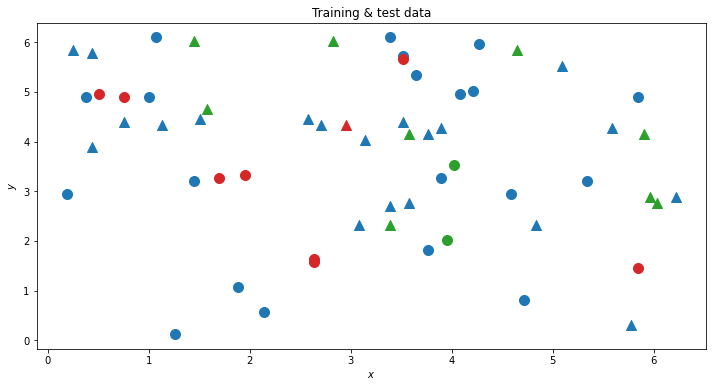

In [47]:
plt.figure(figsize=(12,6))

for feature, label in zip(training_features, training_labels):
    marker = 'o' if label[0] == 1 else '^'
    plt.scatter(feature[0], feature[1], marker=marker, s=100, color='tab:blue')
    
for feature, label, predicted in zip(test_features, test_labels, my_predicted_labels):
    marker = 'o' if label[0] == 1 else '^'
    color = 'tab:green' if label[0] == predicted else 'tab:red'
    plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
plt.title('Training & test data')
plt.xlabel('$x$')
plt.ylabel('$y$');